# Stroke Predicton - Feature Selection and Logistic Regression

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier 
import matplotlib.pyplot as plt 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None
import statsmodels.api as sm
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
X_train_oversampled = pd.read_csv('X_train_oversampled.csv')
y_train_oversampled = pd.read_csv('y_train_oversampled.csv')
X_test = pd.read_csv('X_test.csv')
y_test = pd.read_csv('y_test.csv')

## chi-squared

Nesta fase, utilizamos o método Qui-Quadrado para tentar perceber a importancia das features. Segundo os resultados deste método, a variavel independente "Age" é a mais importante para explicar o "Stroke". A feature "Avg_glucose_level" também apresenta um score elevado neste metodo estatístico, podendo ser relativamente importante no desenvolvimento dos modelos. 

In [3]:
X_chi = X_train_oversampled  #independent columns
y_chi = y_train_oversampled   #target column 

#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X_chi, y_chi)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_chi.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(21,'Score'))  #print 21 best features

                             Specs         Score
0                              age  18974.784194
3                avg_glucose_level  10789.788495
14              work_type_children    446.000000
8                  ever_married_No    441.918298
2                    heart_disease    321.231953
1                     hypertension    229.799273
17          smoking_status_Unknown    149.788677
9                 ever_married_Yes    134.916718
4                              bmi     97.501700
18  smoking_status_formerly smoked     89.690984
13         work_type_Self-employed     57.174652
20           smoking_status_smokes     23.846366
11          work_type_Never_worked     10.000000
10              work_type_Govt_job      4.708185
12               work_type_Private      3.915753
6                      gender_Male      3.180949
5                    gender_Female      2.343300
7                     gender_Other      1.000000
19     smoking_status_never smoked      0.890893
15            Reside

## Extra Tree Classifier

Outro método utilizado foi o extra Tree Classifier que teve resultados bastante identicos ao método anterior, subindo o bmi na classificação. 

In [4]:
X_etc = X_train_oversampled  # colunas independentes 
y_etc = y_train_oversampled  #target column 

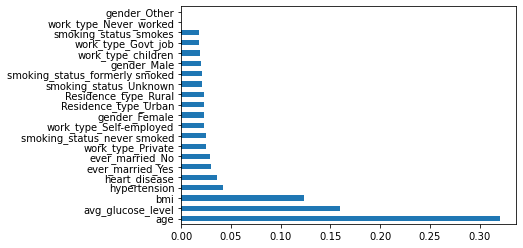

In [5]:
model = ExtraTreesClassifier() 
model.fit(X_etc, y_etc) 
#plot gráfico de importâncias de recursos para melhor visualização 
feat_importances = pd.Series(model.feature_importances_, index = X_etc.columns) 
feat_importances.nlargest(21).plot(kind = 'barh') 
plt.show()

## Recursive Feature Elemination

Através do Recursive Features Elemination, e utilizando o dataset com os dados sintéticos incluidos, podemos verificar que os valores da accuracy podem ter sofrido um sobreajuste nos resultados de treino, passando os 99% de accuracy.

Optimal number of features: 10


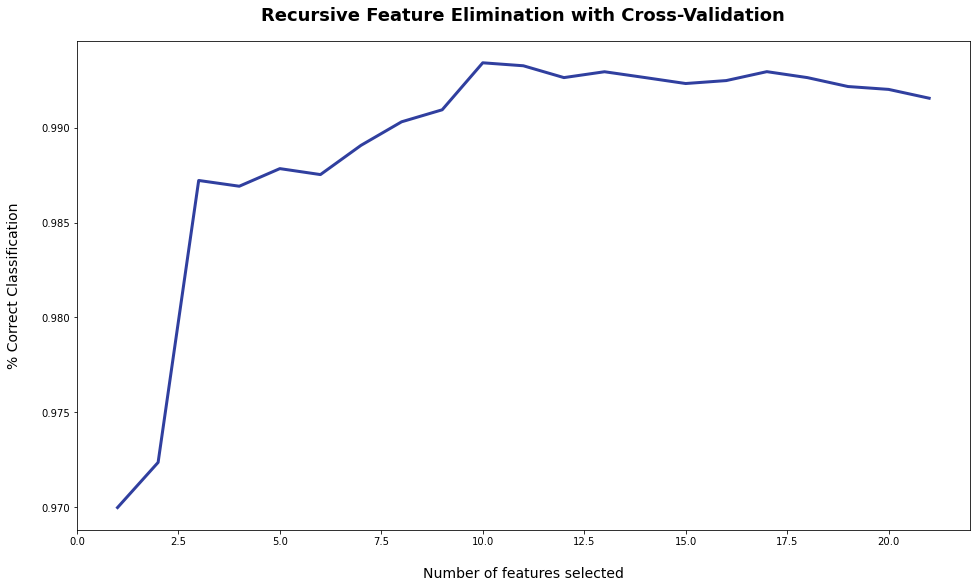

In [6]:
X_r = pd.read_csv('X_train_oversampled.csv')
y_r = pd.read_csv('y_train_oversampled.csv')

rfc = RandomForestClassifier(random_state=101)
rfecv = RFECV(estimator=rfc, step=1, cv=StratifiedKFold(5), scoring='f1')
rfecv.fit(X_r, y_r)
print('Optimal number of features: {}'.format(rfecv.n_features_))

plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

plt.show()

Este método alcançou os melhores resultados com apenas 10 features descritas em baixo. Importa referir que o modelo deste método, neste caso, é o random forest. 

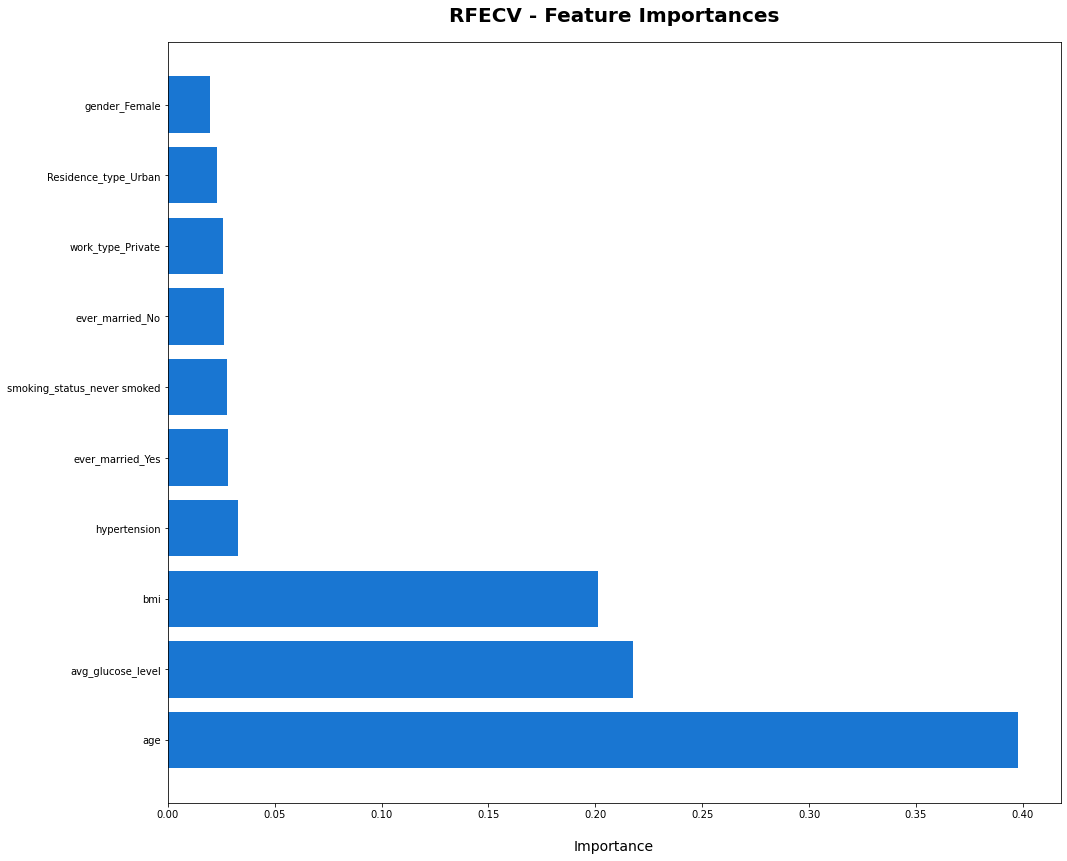

In [7]:
X_r.drop(X_r.columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)

dset = pd.DataFrame()
dset['attr'] = X_r.columns
dset['importance'] = rfecv.estimator_.feature_importances_

dset = dset.sort_values(by='importance', ascending=False)
plt.figure(figsize=(16, 14))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()

## Detecting Multicollinearity with Variance Inflation Factor

Utilizamos a função VIF para verificar se as variáveis númericas continuas apresentam problemas de multicolineariedade, os resultados obtidos, como são abaixo de 10, consideramos que não. 

In [8]:
# VIF dataframe
data = X_train[['age','avg_glucose_level', 'bmi']]
vif_data = pd.DataFrame()
vif_data["feature"] = data.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(data.values, i)
                          for i in range(len(data.columns))]
  
print(vif_data)

             feature       VIF
0                age  5.386049
1  avg_glucose_level  5.881975
2                bmi  7.906306


## Logistic Regression Report Function

In [9]:
def lr(X_train, y_train, X_test, y_test):
    logreg = LogisticRegression()
    logreg = logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    accuracy = logreg.score(X_test, y_test)
    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred)
    logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
    return logreg, accuracy, cm, cr, logit_roc_auc, fpr, tpr, thresholds


## Logistic Regression - Unbalanced

Desenvolvendo o primeiro modelo de Regressão Logistica, ainda com os dados balanceados, pode observar-se que o resultado da accuracy é cerca de 95 %. Apesar de ser alto este modelo não nos serve de nada, porque preve corretamente 0% dos casos stroke. 

Accuracy of logistic regression classifier on test set: 0.95
[[1695    0]
 [  94    0]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1695
           1       0.00      0.00      0.00        94

    accuracy                           0.95      1789
   macro avg       0.47      0.50      0.49      1789
weighted avg       0.90      0.95      0.92      1789



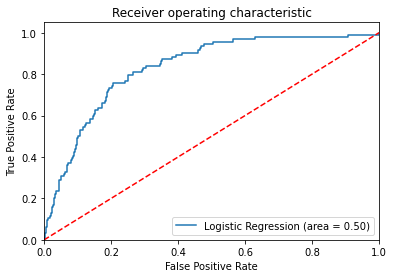

In [10]:
logreg, accuracy, cm, cr, logit_roc_auc, fpr, tpr, thresholds = lr(X_train, y_train, X_test, y_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(accuracy))
print(cm)
print(cr)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

## Logistic Regression - Balanced

Utilizando os dados balanceados(o dataset com dados sintéticos) a accuracy diminui consideravelmente mas os resultados são mais favoraveis porque o modelo é capaz de prever cerca de 80% dos casos de Stroke do dataset de teste. 

Accuracy of logistic regression classifier on test set: 0.72
[[1217  478]
 [  19   75]]
              precision    recall  f1-score   support

           0       0.98      0.72      0.83      1695
           1       0.14      0.80      0.23        94

    accuracy                           0.72      1789
   macro avg       0.56      0.76      0.53      1789
weighted avg       0.94      0.72      0.80      1789



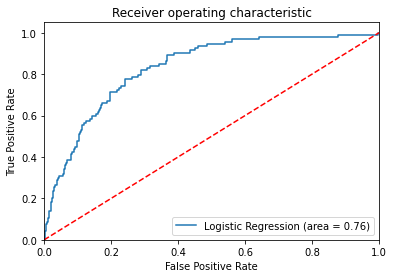

In [11]:
logreg, accuracy, cm, cr, logit_roc_auc, fpr, tpr, thresholds = lr(X_train_oversampled, y_train_oversampled, X_test, y_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(accuracy))
print(cm)
print(cr)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

## Logistic Regression - Feature Selection

Por fim, utilizando apenas as 10 features que foram selecionadas pelo metodo RFE, pode observar-se que os resultados são muito parecidos com o do modelo anterior, podendo ser uma decisão do grupo de trabalho só utilizar estas variáveis em modelos futuros. 

Accuracy of logistic regression classifier on test set: 0.72
[[1212  483]
 [  18   76]]
              precision    recall  f1-score   support

           0       0.99      0.72      0.83      1695
           1       0.14      0.81      0.23        94

    accuracy                           0.72      1789
   macro avg       0.56      0.76      0.53      1789
weighted avg       0.94      0.72      0.80      1789



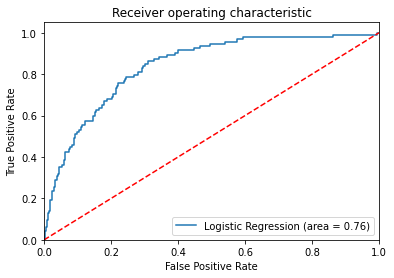

In [14]:
X_F = X_test[['age', 'hypertension', 'avg_glucose_level', 'bmi', 'gender_Female',
       'ever_married_No', 'ever_married_Yes', 'work_type_Private',
       'Residence_type_Urban', 'smoking_status_never smoked']]

logreg, accuracy, cm, cr, logit_roc_auc, fpr, tpr, thresholds = lr(X_r, y_train_oversampled, X_F, y_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(accuracy))
print(cm)
print(cr)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()